# Drug–Target Interaction Prediction


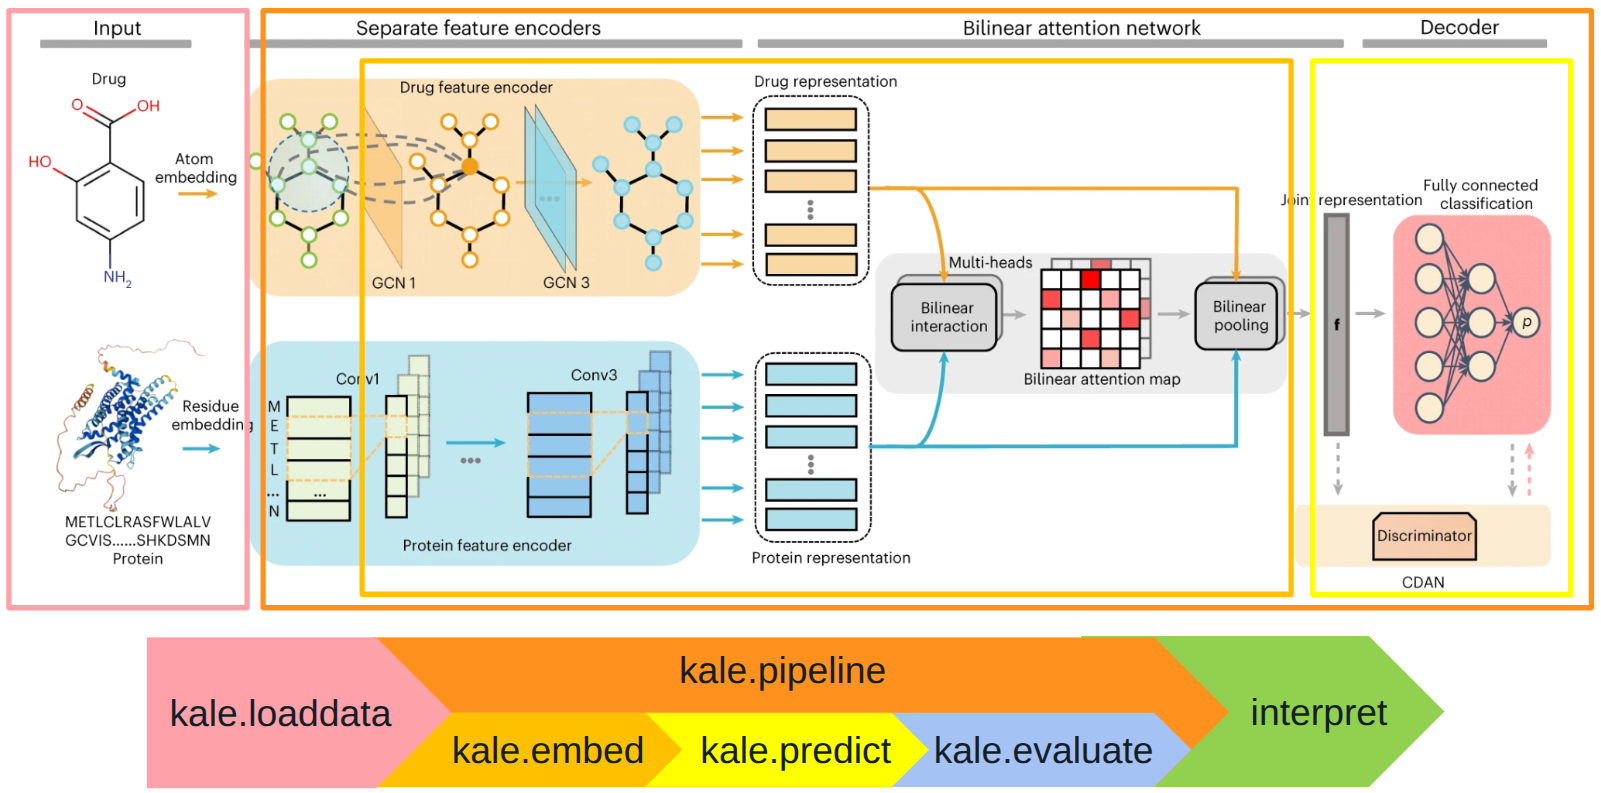

In this tutorial, we will train models to predict the interaction between **two data modalities**: **molecules (drug)** and **proteins (target)** using `PyKale`. Drug-target interaction (DTI) plays a key role in drug discovery and identifying potential therapeutic targets. This example is based on the **DrugBAN** framework by [**Bai et al. (_Nature Machine Intelligence_, 2023)**](https://www.nature.com/articles/s42256-022-00605-1).

The DTI prediction problem is formulated as a **binary classification task**, where the goal is to predict whether a given **drug–protein pair interacts or not**. The DrugBAN framework tackles this problem using two key ideas:

- **Bilinear Attention Network (BAN)**, which learns detailed feature representations for both drugs and proteins and captures local interaction patterns between them.

- **Adversarial Domain Adaptation**, which helps the model generalise to out-of-distribution datasets, improving its ability to predict interactions on unseen drug–target pairs.

With `PyKale`, implementing such a multimodal DTI prediction pipeline is straightforward. The library provides ready-to-use modules and configuration support, making it easy to apply advanced techniques with minimal custom coding.

## Step 0: Environment Preparation

As a starting point, we will install the required packages and load a set of helper functions to assist throughout this tutorial.

To prepare the helper functions and necessary materials, we download them from the GitHub repository.

Moreover, we provide helper functions that can be inspected directly in the `.py` files located in the notebook's current directory. The additional helper script is:
- [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs.py): Defines the base configuration settings, which can be overridden using a custom `.yaml` file.

In [ ]:
!rm -rf /content/mmai-tutorials
!git clone --branch drug-target https://github.com/pykale/mmai-tutorials.git
%cd /content/mmai-tutorials/tutorials/drug-target-interaction

### Package Installation

The main package required for this tutorial is `PyKale`.

`PyKale` is an open-source interdisciplinary machine learning library developed at the University of Sheffield, with a focus on applications in biomedical and scientific domains.

In [ ]:
!pip install --quiet git+https://github.com/pykale/pykale@main\
    && echo "PyKale installed successfully ✅" \
    || echo "Failed to install PyKale ❌"

Then, we install `PyG` (PyTorch Geometric) and related packages.

Please **do not** re-run this session after installation completed. Runing this installation multiple times will trigger issues related to `PyG`. If you want to re-run this installation, please click the `Runtime` on the top menu and choose `Disconnect and delete runtime` before installing.

In [ ]:
import torch
import os
os.environ['TORCH'] = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git \
    && echo "PyG installed successfully ✅" \
    || echo "Failed to install PyG ❌"

!pip install rdkit-pypi \
    && echo "rdkit installed successfully ✅" \
    || echo "Failed to install rdkit ❌"

Then, we install other required packages in [`mmai-tutorials/requirements.txt`](https://github.com/pykale/mmai-tutorial/blob/main/requirements.txt).

In [ ]:
%cd /content/mmai-tutorials/tutorials/drug-target-interaction

!pip install --quiet -r /content/mmai-tutorials/requirements.txt \
    && echo "Required packages installed successfully ✅" \
    || echo "Failed to install required packages ❌"

Please run the following block to reinstall `NumPy` to avoid bugs.

In [ ]:
import os

!pip install --upgrade --force-reinstall numpy==2.0.0
os.kill(os.getpid(), 9)

Install yacs

In [ ]:
!pip install yacs

We then hide the warnings messages to get a clear output.

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

Exercise: Check NumPy Version

In [ ]:
import numpy as np

print("NumPy version:", np.__version__)  # numpy should be 2.0.0

### Configuration

To minimize the footprint of the notebook when specifying configurations, we provide a [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs.py) file that defines default parameters. These can be customized by supplying a `.yaml` configuration file, such as [`experiments/DA_cross_domain.yaml`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/experiments/DA_cross_domain.yaml) as an example.

In [ ]:
%cd /content/mmai-tutorials/tutorials/drug-target-interaction

from configs import get_cfg_defaults

cfg = get_cfg_defaults()  # Load the default settings from config.py
cfg.merge_from_file(
    "experiments/DA_cross_domain.yaml"
)  # Update (or override) some of those settings using a custom YAML file

In this tutorial, we list the hyperparameters we would like users to play with outside the `.yaml` file:
- `cfg.SOLVER.MAX_EPOCH`: Number of epochs in training stage. You can reduce the number of training epochs to shorten runtime.
- `cfg.DATA.DATASET`: The dataset used in the study. This can be `bindingdb` or `biosnap`.

As a quick exercise, please take a moment to review and understand the parameters in [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs.py).

In [ ]:
cfg.SOLVER.MAX_EPOCH = 2

You can also switch to a different dataset.

In [ ]:
cfg.DATA.DATASET = "biosnap"

Exercise: Now print the full configuration to check all current hyperparameter and dataset settings.

In [ ]:
print(cfg)

## Step 1: Data Loading and Preparation

In this tutorial, we use the **Biosnap** dataset for the main demonstration and the **BindingDB** dataset for the exercise at the end.

### Data downloading

Please using the following codes to download necessary datasets.

In [ ]:
!rm -rf data
!mkdir data
!cd data

!pip install -q gdown
!gdown --id 1ogOcxZn-1q418LOT-gQ94aHQV0Y1sOmk --output data/drug-target-interaction.zip
!unzip data/drug-target-interaction.zip -d data/

Exercise: Check the data is ready

In [ ]:
import os
import shutil

print("Contents of the folder:")
for item in os.listdir("data/drug-target-interaction"):
    print(item)

Each dataset folder follows the structure:

```sh
    ├───dataset_name
    │   ├───cluster
    │   │   ├───source_train.csv
    │   │   ├───target_train.csv
    │   │   ├───target_test.csv
    │   ├───random
    │   │   ├───test.csv
    │   │   ├───train.csv
    │   │   ├───val.csv
    │   ├───full.csv
```

We use the cluster dataset folder for cross-domain prediction, containing three parts:

- Train samples from the source domain: Drug–protein pairs the model learns from.

- Train samples from the target domain: Additional training data from a different distribution to improve generalisation.

- Test samples from the target domain: Unseen drug–protein pairs used to evaluate model performance on new data.

### Data loading

Here’s what each csv file looks like in a table format:

| SMILES             | Protein Sequence         | Y |
|--------------------|--------------------------|---|
| Fc1ccc(C2(COC…)    | MDNVLPVDSDLS…            | 1 |
| O=c1oc2c(O)c(…)    | MMYSKLLTLTTL…            | 0 |
| CC(C)Oc1cc(N…)     | MGMACLTMTEME…            | 1 |

Each row of the dataset contains three key pieces of information:

**Drugs**:  
Drugs are often written as SMILES strings, which are like chemical formulas in text format (for example, `"CC(=O)OC1=CC=CC=C1C(=O)O"` is aspirin).  


**Protein Sequence**  
This is a string of letters where each letter stands for an amino acid, the building blocks of proteins. For example, `MGYTSLLT...` is a short protein sequence.


**Y (Labels)**:  
Each drug–protein pair is given a label:
- `1` if they interact
- `0` if they do not


Each row shows one drug–protein pair. The goal of our machine learning model is to predict the last column (**Y**) — whether or not the drug and protein interact.

You can load CSV files into Python using tools like `pandas`.

In [ ]:
import pandas as pd

dataFolder = os.path.join(
    f"data/drug-target-interaction/{cfg.DATA.DATASET}", str(cfg.DATA.SPLIT)
)

df_train_source = pd.read_csv(os.path.join(dataFolder, "source_train.csv"))
df_train_target = pd.read_csv(os.path.join(dataFolder, "target_train.csv"))
df_test_target = pd.read_csv(os.path.join(dataFolder, "target_test.csv"))

### Data Preprocessing

We convert drug SMILES strings into molecular graphs using `kale.loaddata.molecular_datasets.smiles_to_graph`, encoding atom-level features as node attributes and bond types as edges.


Protein sequences are transformed into fixed-length integer arrays using `kale.prepdata.chem_transform.integer_label_protein`, with each amino acid mapped to an integer and sequences padded or truncated to a uniform length.

Finally, the `kale.loaddata.molecular_datasets.DTIDataset` class packages drugs, proteins, and labels into a PyTorch-ready dataset.

**Note:** If you encounter an error related to requiring numpy `<2.0`, simply ignore it and re-run this block until it completes successfully.

In [ ]:
from kale.loaddata.molecular_datasets import DTIDataset

# Create preprocessed datasets
train_dataset = DTIDataset(df_train_source.index.values, df_train_source)
train_target_dataset = DTIDataset(df_train_target.index.values, df_train_target)
test_target_dataset = DTIDataset(df_test_target.index.values, df_test_target)

We load data in small, manageable pieces called batches to save memory and speed up training. We use `kale.loaddata.sampler.MultiDataLoader` from PyKale to load one batch from the source domain and one from the target domain at each training step.

First, we specify a few DataLoader parameters:
- Batch size: Number of samples per batch
- Shuffle: Randomly shuffle data
- Number of workers: Parallel data loading
- Drop last: Discard the last incomplete batch for consistent batch sizes
- Collate function: Use graph_collate_func to batch variable-sized molecular graphs

In [ ]:
from torch.utils.data import DataLoader
from kale.loaddata.molecular_datasets import graph_collate_func
from kale.loaddata.sampler import MultiDataLoader

params = {
    "batch_size": cfg.SOLVER.BATCH_SIZE,
    "shuffle": True,
    "num_workers": cfg.SOLVER.NUM_WORKERS,
    "drop_last": True,
    "collate_fn": graph_collate_func,
}

Then, we create a DataLoader from both the source and target datasets for training.

In [ ]:
if not cfg.DA.USE:
    training_generator = DataLoader(train_dataset, **params)
else:
    source_generator = DataLoader(train_dataset, **params)
    target_generator = DataLoader(train_target_dataset, **params)

    # Get the number of batches in the longer dataset to align both
    n_batches = max(len(source_generator), len(target_generator))

    # Combine the source and target data loaders using MultiDataLoader
    training_generator = MultiDataLoader(
        dataloaders=[source_generator, target_generator], n_batches=n_batches
    )

Lastly, we set up DataLoaders for validation and testing. Since we don’t want to shuffle or drop any samples, we adjust the parameters accordingly.

In [ ]:
# Update parameters for validation/testing (no shuffling, keep all data)
params.update({"shuffle": False, "drop_last": False})

# Create validation and test data loaders
valid_generator = DataLoader(test_target_dataset, **params)
test_generator = DataLoader(test_target_dataset, **params)

### Exercise: Dataset Inspection

Once the dataset is ready, let’s inspect one sample from the training data to check the input graph, protein sequence, and label format.

In [ ]:
# Get the first batch (contains one batch from source and one from target)
first_batch = next(iter(training_generator))

# Unpack source and target batches
source_batch, target_batch = first_batch

# Inspect the first sample from the source batch
print("First sample from source batch:")
print("Drug graph:", source_batch[0][0])
print("Protein sequence:", source_batch[1][0])
print("Label:", source_batch[2][0])

This sample is a tuple with three parts:

1. **Drug Graph**
- `x=[290, 7]`: Feature matrix with 290 atoms (nodes) and 7 features per atom.
- `edge_index=[2, 58]`: Shows 146 edges, with source and target node indices.
- `edge_attr=[58, 1]`: Each edge has 1 bond feature, such as bond type.
- `num_nodes=290`: Confirms the graph has 290 nodes.

2. **Protein Features (array)**
- Example values: `[11.,  1., 18., ...,  0.,  0.,  0.]`: A fixed-length numeric array representing the protein sequence. Each position holds an integer-encoded amino acid, with zeros for padding.

3. **Label (float)**
- `0.0`; The ground-truth interaction label indicating no interaction.

## Step 2: Model Definition

### Embed

DrugBAN consists of three main components: a Graph Convolutional Network (GCN) for extracting structural features from drug molecular graphs, a Convolutional Neural Network (CNN) for encoding protein sequences, and a Bilinear Attention Network (BAN) for fusing drug and protein features. The fused representation is then passed through a Multi-Layer Perceptron (MLP) classifier to predict interaction scores.

We define the DrugBAN class in `kale.embed.ban`.

In [ ]:
from kale.embed.ban import DrugBAN

model = DrugBAN(**cfg)
print(model)

### Predict
We use the training class `kale.pipeline.drugban_trainer`, which handles model training, domain adaptation, and evaluation for DrugBAN.

In [ ]:
from kale.pipeline.drugban_trainer import DrugbanTrainer

drugban_trainer = DrugbanTrainer(
    model=DrugBAN(**cfg),
    solver_lr=cfg["SOLVER"]["LEARNING_RATE"],
    num_classes=cfg["DECODER"]["BINARY"],
    batch_size=cfg["SOLVER"]["BATCH_SIZE"],
    is_da=cfg["DA"]["USE"],
    solver_da_lr=cfg["SOLVER"]["DA_LEARNING_RATE"],
    da_init_epoch=cfg["DA"]["INIT_EPOCH"],
    da_method=cfg["DA"]["METHOD"],
    original_random=cfg["DA"]["ORIGINAL_RANDOM"],
    use_da_entropy=cfg["DA"]["USE_ENTROPY"],
    da_random_layer=cfg["DA"]["RANDOM_LAYER"],
    da_random_dim=cfg["DA"]["RANDOM_DIM"],
    decoder_in_dim=cfg["DECODER"]["IN_DIM"],
)

We want to save the best model during training so we can reuse it later without needing to retrain. PyTorch Lightning’s `ModelCheckpoint` does this by automatically saving the model whenever it achieves a new best validation AUROC score.

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename="{epoch}-{step}-{val_BinaryAUROC:.4f}",
    monitor="val_BinaryAUROC",
    mode="max",
)

We now create the `Trainer`.

In [ ]:
import torch

trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    devices="auto",
    accelerator="auto",
    max_epochs=cfg["SOLVER"]["MAX_EPOCH"],
    deterministic=True,
)

## Step 3: Model Training

### Train

After setting up the model and data loaders, we now start training the full DrugBAN model using the PyTorch Lightning Trainer via calling `trainer.fit()`.

#### What Happens Here?
- The model receives batches of drug-protein pairs from the training data loader.

- During each step, the GCN, CNN, BAN layer, and MLP classifier are updated to improve interaction prediction.

- Validation is automatically run at the end of each epoch to track performance and save the best model based on AUROC.


This code block takes approximately 5 minutes to complete.

In [ ]:
trainer.fit(
    drugban_trainer,
    train_dataloaders=training_generator,
    val_dataloaders=valid_generator,
)

## Step 4: Evaluation

Once training is complete, we evaluate the model on the test set using `trainer.test()`.

#### What is included in this step?
- The best model checkpoint (based on validation AUROC) is automatically loaded.

- The model runs on the test data to generate predictions.

- Final classification metrics, including AUROC, F1 score, accuracy, sensitivity, and specificity, are calculated and logged.

In [ ]:
trainer.test(drugban_trainer, dataloaders=test_generator, ckpt_path="best")

### Performance comparison

The earlier example was a simple demonstration. To properly evaluate DrugBAN against baseline models, we train it for 100 epochs across multiple random seeds.

The figure below shows the performance of different models on the BioSNAP and BindingDB datasets:
- Left plot: AUROC (Area Under the ROC Curve)
- Right plot: AUPRC (Area Under the Precision–Recall Curve)

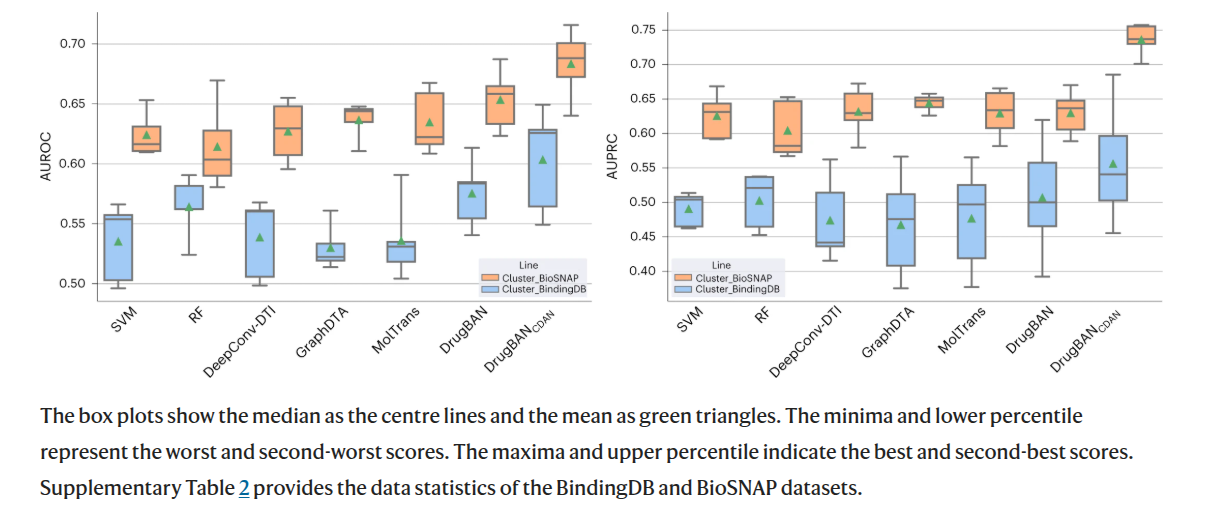

## Step 5: Interpretation

Although we don’t perform this step in the tutorial, for your information, it is possible to explore how DrugBAN internally represents drugs and proteins by extracting intermediate embeddings.

The model first processes drug graphs and protein sequences through separate modules, then fuses them using bilinear attention to create a joint representation. These embeddings—drug embedding, protein embedding, and joint interaction embedding—help reveal what structural and sequence features the model has learned and how it encodes drug-protein interactions.

This is typically done during the evaluation phase to avoid affecting the model’s weights or training behaviour.

## Extension Tasks

### Task 1

To use the BindingDB dataset, modify the relevant line in the Configuration section of Step 0 as shown below.

```python
cfg.DATA.DATASET = "bindingdb"
```

Reload the dataset and re-run training and testing.

> Tip: See if the model struggles more or less with the new dataset. It can reveal how generalisable DrugBAN is.


### Task 2

Turn off domain adaptation by updating the config file and re-running training and testing.

Replace `experiments/DA_cross_domain.yaml` with `experiments/non_DA_cross_domain.yaml` in the Configuration section of Step 0 as shown below.

```python
cfg.merge_from_file("experiments/non_DA_cross_domain.yaml")
```
>Tip: Compare the results with and without domain adaptation to see how it affects model performance.